In [14]:
import numpy as np
import time, os, sys
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300
from cellpose import utils, io, models, plot
from pathlib import Path
import os
from skimage import exposure
import re

In [28]:
nucChannel = 0;
dataDir = os.getcwd(); #'/Users/idse/data_tmp/PGC'
barefilenames = [];
filedirs = [];

for filepath in Path(dataDir).rglob("*FusionStitcher*.ims") :
#     print(filepath)
    filename = str(filepath).split('/')[-1]
    filedir = str(filepath).split(filename)[0]
    barefilename = ''.join(re.split('_FusionStitcher|.ims',filename))
    barefilenames.append(barefilename)
    filedirs.append(filedir)

In [30]:
barefilenames

['210415_MP72_ESI_AP_BLMP_NANG_CTRL_F2',
 '210415_MP72_ESI_AP_BLMP_NANG_CTRL_F3',
 '210415_MP72_ESI_AP_BLMP_NANG_CTRL_F1',
 '210415_MP72_ESI_AP_BLMP_NANG_CTRL_F0',
 '210415_MP96_ESI_AP_BLMP_NANG_CTRL_F3',
 '210415_MP96_ESI_AP_BLMP_NANG_CTRL_F2',
 '210415_MP96_ESI_AP_BLMP_NANG_CTRL_F0',
 '210415_MP96_ESI_AP_BLMP_NANG_CTRL_F1',
 '210415_MP48_ESI_AP_BLMP_NANG_CTRL_10_F2',
 '210415_MP48_ESI_AP_BLMP_NANG_CTRL_10_F3',
 '210415_MP48_ESI_AP_BLMP_NANG_CTRL_10_F1',
 '210415_MP48_ESI_AP_BLMP_NANG_CTRL_10_F0']

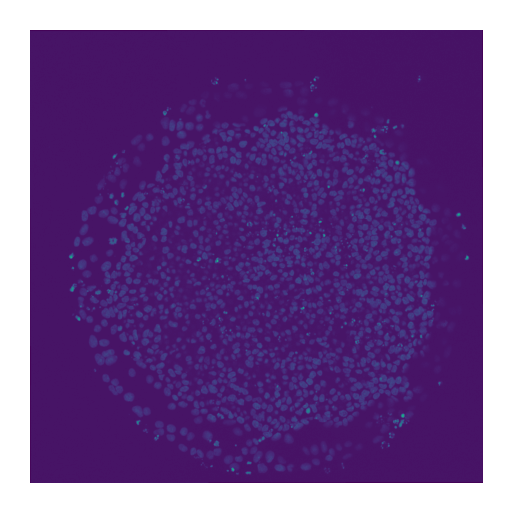

In [5]:
ci = nucChannel; 
zi = 0;
f = barefilenames[0]
slicefilename = filedirs[0] + f + '_zslices/' + f + '_w%.4d_z%.4d.tif' % (ci, zi)

img = io.imread(slicefilename)
plt.figure(figsize=(2,2))
plt.imshow(img)
plt.axis('off')
plt.show()

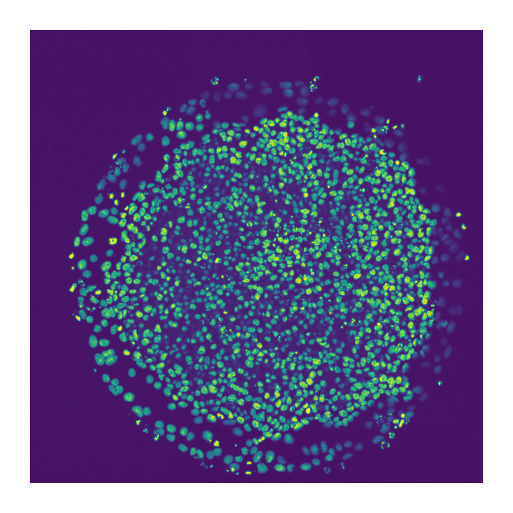

In [6]:
#display image with rescaled + saturated intensity
p1, p99 = np.percentile(img, (1, 99))
J = exposure.rescale_intensity(img, in_range=(p1, p99))

plt.figure(figsize=(2,2))
plt.imshow(J)
plt.axis('off')
plt.show()

In [98]:
#run the model once
#if you set diameter=None in the call to model.eval, it will run the model once to estimate the size of nuclei and run again
#to do actual segmentation but this is slow and works less well on the micropattern than on sparser disordered cells
#I generally estimate in Fiji instead; for 40x, nuclear diameter generally ranges from ~25-70 pixels
model = models.Cellpose(gpu=False, model_type='nuclei')
chan = [0,0] #use chan = [0,0] for nuclear segmentation only
img = io.imread(slicefilename)
p1, p99 = np.percentile(img, (1, 99))
J = exposure.rescale_intensity(img, in_range=(p1, p99))
masks, flows, styles, diams = model.eval(img, diameter=35, channels=chan, net_avg=True)

>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 85.59s; flow+mask computation 7.61
estimated masks for 1 image(s) in 93.46 sec
>>>> TOTAL TIME 93.46 sec


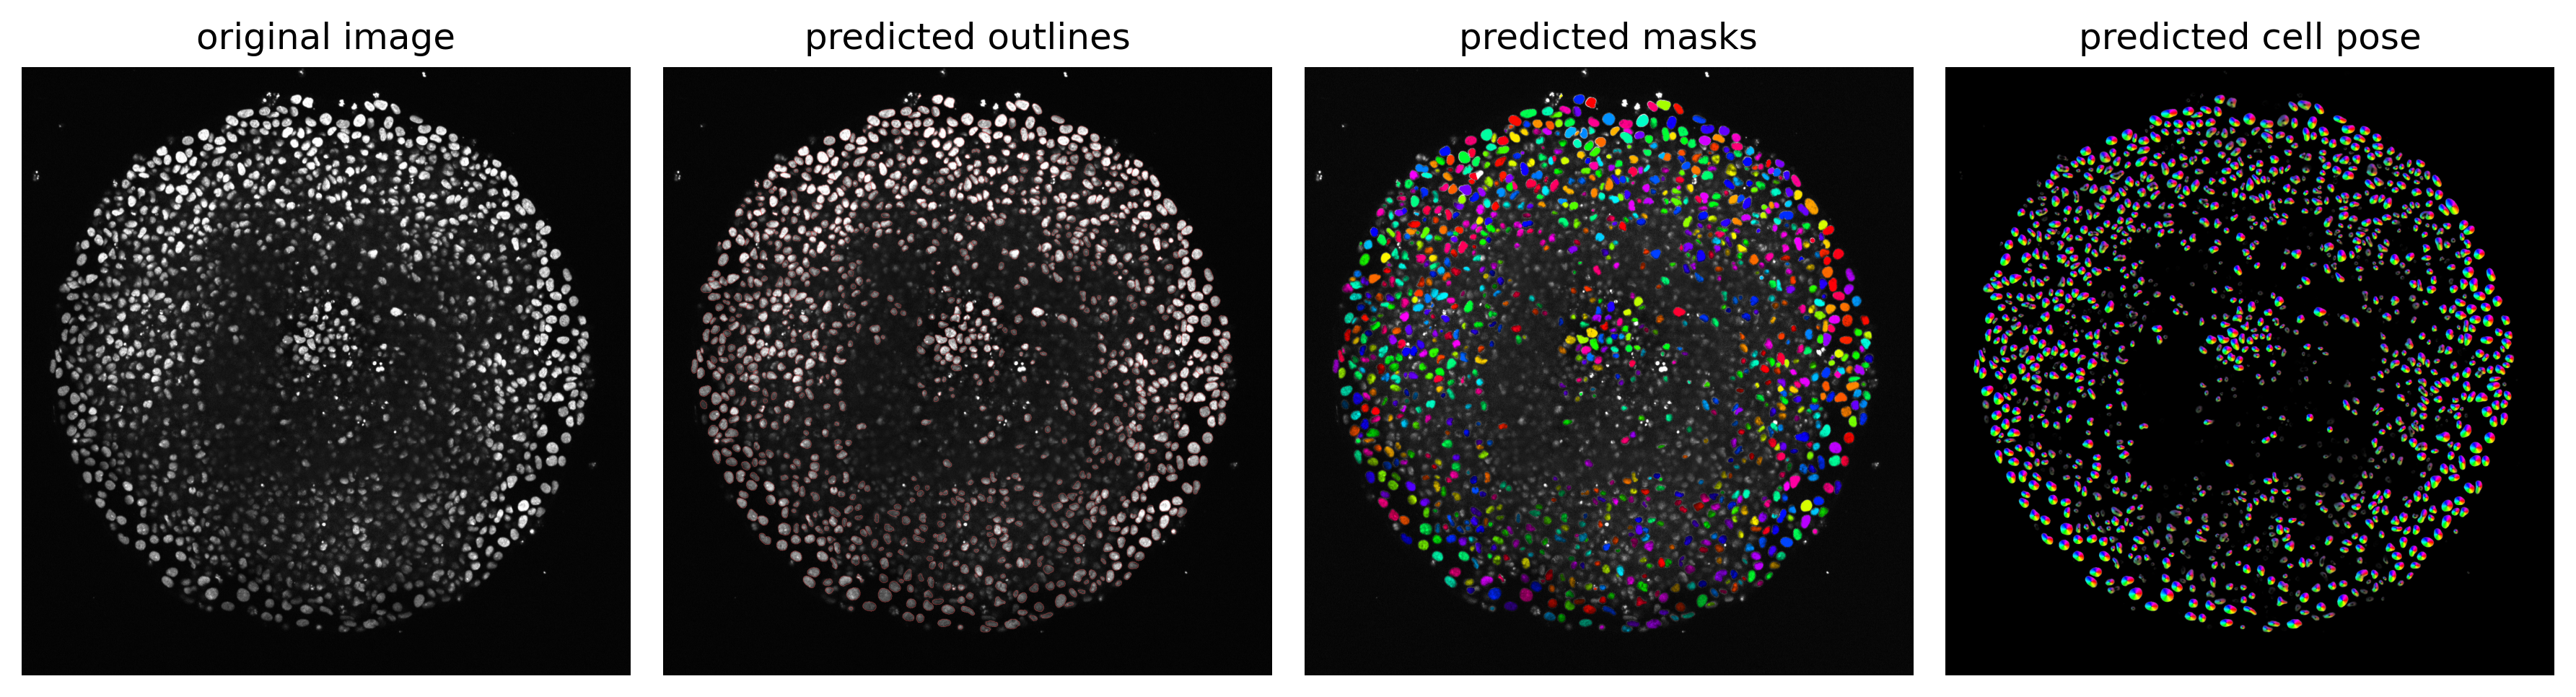

In [99]:
# DISPLAY RESULTS
#The built-in way of doing this is extremely slow, I've been saving results and visualizing in matlab instead
fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, img, masks, flows[0], channels=chan)
plt.tight_layout()
plt.show()n

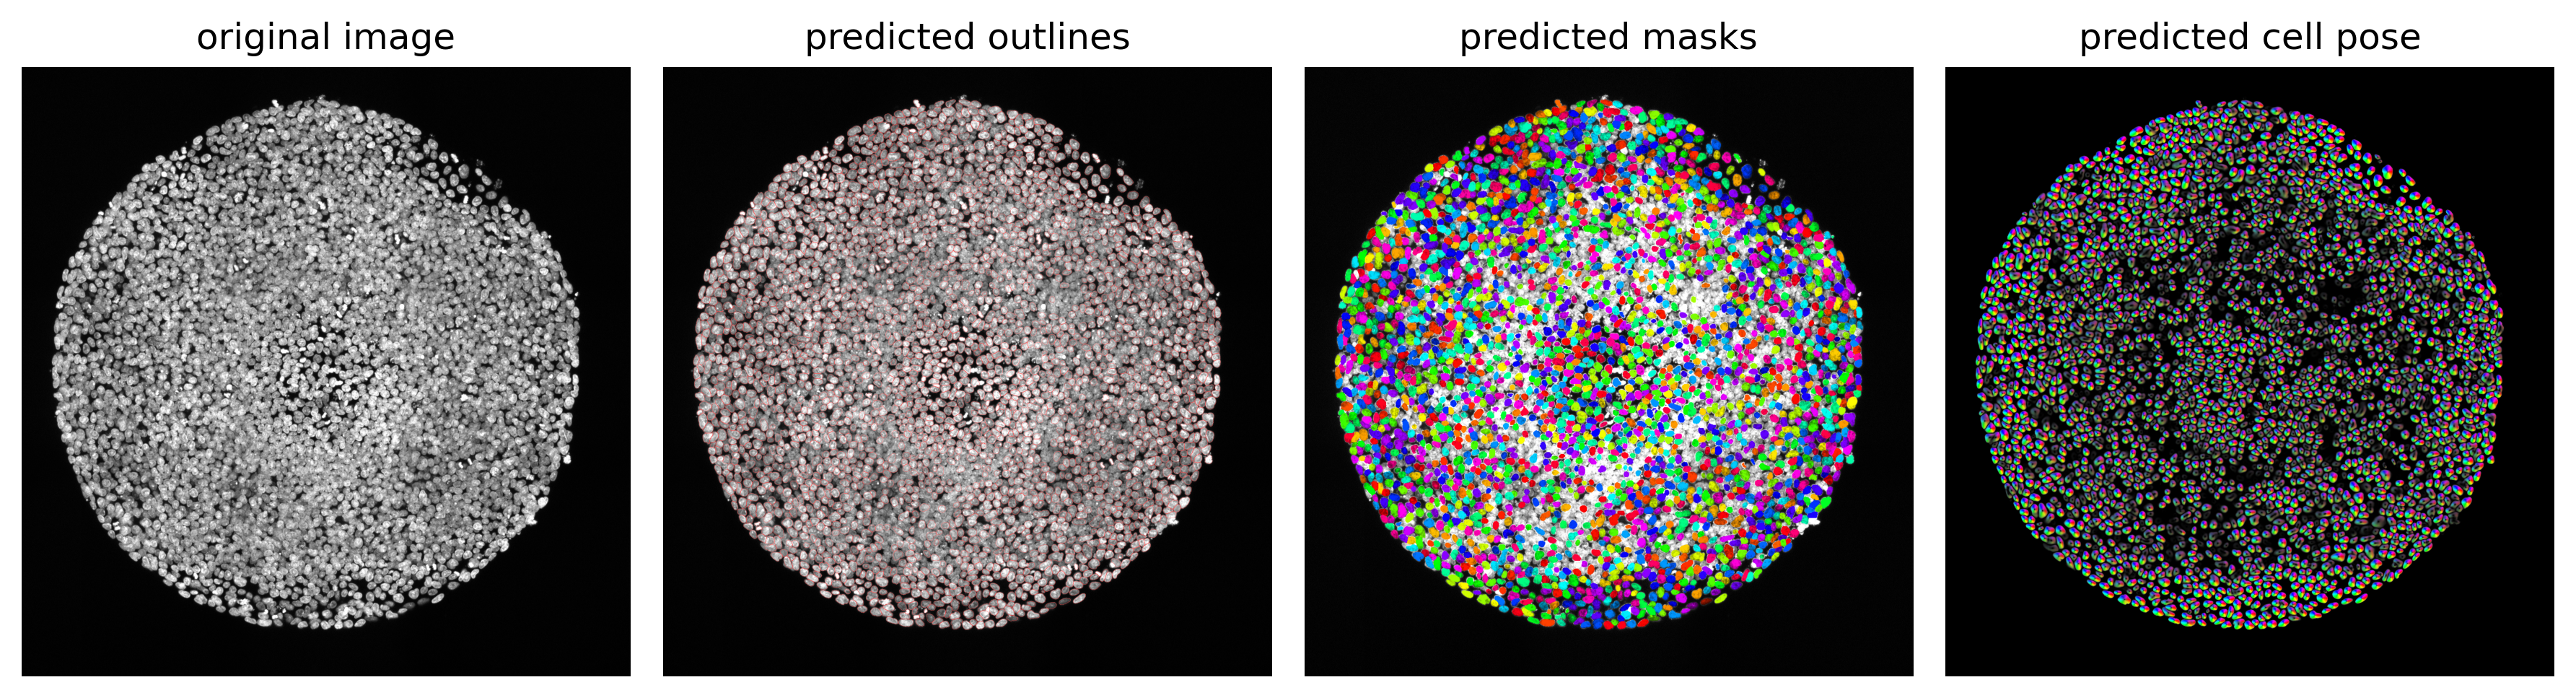

In [4]:
# DISPLAY RESULTS - Seth example
#The built-in way of doing this is extremely slow, I've been saving results and visualizing in matlab instead
fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, img, masks, flows[0], channels=chan)
plt.tight_layout()
plt.show()

In [8]:
# RUN CELLPOSE

#from cellpose import models, io

# DEFINE CELLPOSE MODEL
# model_type='cyto' or model_type='nuclei'
model = models.Cellpose(gpu=True, model_type='nuclei')

# define CHANNELS to run segementation on
# grayscale=0, R=1, G=2, B=3
# channels = [cytoplasm, nucleus]
# if NUCLEUS channel does not exist, set the second channel to 0
# channels = [0,0]
# IF ALL YOUR IMAGES ARE THE SAME TYPE, you can give a list with 2 elements
# channels = [0,0] # IF YOU HAVE GRAYSCALE
# channels = [2,3] # IF YOU HAVE G=cytoplasm and B=nucleus
# channels = [2,1] # IF YOU HAVE G=cytoplasm and R=nucleus

# or if you have different types of channels in each image
channels = [[0,0]]
chan = [0,0]

# if diameter is set to None, the size of the cells is estimated on a per image basis
# you can set the average cell `diameter` in pixels yourself (recommended) 
# diameter can be a list or a single number for all images

# you can run all in a list e.g.
# >>> imgs = [io.imread(filename) in files]
# >>> masks, flows, styles, diams = model.eval(imgs, diameter=None, channels=channels)
# >>> io.masks_flows_to_seg(imgs, masks, flows, diams, files, channels)
# >>> io.save_to_png(imgs, masks, flows, files)

# or in a loop
#for chan, filename in zip(channels, files):
# for filename in files:
#     img = io.imread(filename)
#     J = exposure.rescale_intensity(img, in_range=(p1, p99))
#     masks, flows, styles, diams = model.eval(img, diameter=35, channels=chan, net_avg=True)
#     # save results as png
#     #io.save_to_png(img, masks, flows, filename)
#     base = os.path.splitext(filename)[0]
#     masks = masks.astype(np.uint16) if masks.max()<2**16-1 else masks.astype(np.uint32)
#     io.imsave(base + '_cp_masks.png', masks)

for i in range(len(barefilenames)) :
    
    ci = nucChannel;         

    zi = 0;
    f = barefilenames[i];
    slicefilename = filedirs[i] + f + '_zslices/' + f + '_w%.4d_z%.4d.tif' % (ci, zi)
    
    while os.path.isfile(slicefilename) :

        print(slicefilename)
        img = io.imread(slicefilename)
        
        # adjust contrast limits for each image separately on the bottom slice (this is not for quantitative comparison, only segmentation)
        # if zi == 0 :
        p1, p99 = np.percentile(img, (1, 99))
        
        J = exposure.rescale_intensity(img, in_range=(p1, p99))
        masks, flows, styles, diams = model.eval(img, diameter=35, channels=chan, net_avg=False) # net_avg=True when running on GPU, on CPU false just for speadup
        # save results as png
        # io.save_to_png(img, masks, flows, filename)
        masks = masks.astype(np.uint16) if masks.max()<2**16-1 else masks.astype(np.uint32)
        io.imsave(slicefilename[:-4] + '_cp_masks.png', masks)
    
        zi = zi + 1;
        slicefilename = filedirs[i] + f + '_zslices/' + f + '_w%.4d_z%.4d.tif' % (ci, zi)

TORCH CUDA version not installed/working.
>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
